In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#from urllib import urlretrieve
#import cPickle as pickle
import os
#import gzip

import numpy as np
import theano

import lasagne
from lasagne import layers
from lasagne.updates import adam

#from nolearn.lasagne import NeuralNet
#from nolearn.lasagne import visualize

#from ConvTranspose import Conv3DLayerTransposed

#from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
import theano.tensor as T

from lasagne import init
from lasagne import nonlinearities
from lasagne.utils import as_tuple
from lasagne.theano_extensions import conv

from lasagne.layers.base import Layer

def conv_output_length(input_length, filter_size, stride, pad=0):
    if input_length is None:
        return None
    if pad == 'valid':
        output_length = input_length - filter_size + 1
    elif pad == 'full':
        output_length = input_length + filter_size - 1
    elif pad == 'same':
        output_length = input_length
    elif isinstance(pad, int):
        output_length = input_length + 2 * pad - filter_size + 1
    else:
        raise ValueError('Invalid pad: {0}'.format(pad))

    # This is the integer arithmetic equivalent to
    # np.ceil(output_length / stride)
    output_length = (output_length + stride - 1) // stride

    return output_length


def conv_input_length(output_length, filter_size, stride, pad=0):
      
    if output_length is None:
        return None
    if pad == 'valid':
        pad = 0
    elif pad == 'full':
        pad = filter_size - 1
    elif pad == 'same':
        pad = filter_size // 2
    if not isinstance(pad, int):
        raise ValueError('Invalid pad: {0}'.format(pad))
    return (output_length - 1) * stride - 2 * pad + filter_size


class BaseConvLayer(Layer):
    def __init__(self, incoming, num_filters, filter_size, stride=1, pad=0,
                 untie_biases=False,
                 W=init.GlorotUniform(), b=init.Constant(0.),
                 nonlinearity=nonlinearities.rectify, flip_filters=True,
                 n=None, **kwargs):
        super(BaseConvLayer, self).__init__(incoming, **kwargs)
        if nonlinearity is None:
            self.nonlinearity = nonlinearities.identity
        else:
            self.nonlinearity = nonlinearity

        if n is None:
            n = len(self.input_shape) - 2
        elif n != len(self.input_shape) - 2:
            raise ValueError("Tried to create a %dD convolution layer with "
                             "input shape %r. Expected %d input dimensions "
                             "(batchsize, channels, %d spatial dimensions)." %
                             (n, self.input_shape, n+2, n))
        self.n = n
        self.num_filters = num_filters
        self.filter_size = as_tuple(filter_size, n, int)
        self.flip_filters = flip_filters
        self.stride = as_tuple(stride, n, int)
        self.untie_biases = untie_biases

        if pad == 'same':
            if any(s % 2 == 0 for s in self.filter_size):
                raise NotImplementedError(
                    '`same` padding requires odd filter size.')
        if pad == 'valid':
            self.pad = as_tuple(0, n)
        elif pad in ('full', 'same'):
            self.pad = pad
        else:
            self.pad = as_tuple(pad, n, int)

        self.W = self.add_param(W, self.get_W_shape(), name="W")
        if b is None:
            self.b = None
        else:
            if self.untie_biases:
                biases_shape = (num_filters,) + self.output_shape[2:]
            else:
                biases_shape = (num_filters,)
            self.b = self.add_param(b, biases_shape, name="b",
                                    regularizable=False)

    def get_W_shape(self):
        """Get the shape of the weight matrix `W`.
        Returns
        -------
        tuple of int
            The shape of the weight matrix.
        """
        num_input_channels = self.input_shape[1]
        return (self.num_filters, num_input_channels) + self.filter_size

    def get_output_shape_for(self, input_shape):
        pad = self.pad if isinstance(self.pad, tuple) else (self.pad,) * self.n
        batchsize = input_shape[0]
        return ((batchsize, self.num_filters) +
                tuple(conv_output_length(input, filter, stride, p)
                      for input, filter, stride, p
                      in zip(input_shape[2:], self.filter_size,
                             self.stride, pad)))

    def get_output_for(self, input, **kwargs):
        conved = self.convolve(input, **kwargs)

        if self.b is None:
            activation = conved
        elif self.untie_biases:
            activation = conved + T.shape_padleft(self.b, 1)
        else:
            activation = conved + self.b.dimshuffle(('x', 0) + ('x',) * self.n)

        return self.nonlinearity(activation)

    def convolve(self, input, **kwargs):
        """
        Symbolically convolves `input` with ``self.W``, producing an output of
        shape ``self.output_shape``. To be implemented by subclasses.
        Parameters
        ----------
        input : Theano tensor
            The input minibatch to convolve
        **kwargs
            Any additional keyword arguments from :meth:`get_output_for`
        Returns
        -------
        Theano tensor
            `input` convolved according to the configuration of this layer,
            without any bias or nonlinearity applied.
        """
        raise NotImplementedError("BaseConvLayer does not implement the "
                                  "convolve() method. You will want to "
                                  "use a subclass such as Conv2DLayer.")

class Conv3DLayerTransposed(BaseConvLayer):

    #pad spremenim v crop, flip_filters nastavim na True, spremenim super()
    def __init__(self, incoming, num_filters, filter_size, stride=(1, 1, 1),
                 crop=0, untie_biases=False,
                 W=init.GlorotUniform(), b=init.Constant(0.),
                 nonlinearity=nonlinearities.rectify, flip_filters=False,
                 convolution=T.nnet.ConvTransp3D, output_size=None, **kwargs):
        super(Conv3DLayerTransposed, self).__init__(incoming, num_filters, filter_size,
                                          stride, crop, untie_biases, W, b,
                                          nonlinearity, flip_filters, n=3,
                                          **kwargs)
        self.crop = self.pad
        del self.pad
        self.convolution = convolution
        self.output_size = output_size
        
    def get_W_shape(self):
        num_input_channels = self.input_shape[1]
        # first two sizes are swapped compared to a forward convolution
        return (num_input_channels, self.num_filters) + self.filter_size
    
    def get_output_shape_for(self, input_shape):
        #if self.output_size is not None:
         #   size = self.output_size
        #     if isinstance(self.output_size, T.Variable):
        #        size = (None, None)
        #    return input_shape[0], self.num_filters, size[0], size[1]

        # If self.output_size is not specified, return the smallest shape
        # when called from the constructor, self.crop is still called self.pad:
        crop = getattr(self, 'crop', getattr(self, 'pad', None))
        crop = crop if isinstance(crop, tuple) else (crop,) * self.n
        batchsize = input_shape[0]
        return ((batchsize, self.num_filters) +
                tuple(conv_input_length(input, filter, stride, p)
                      for input, filter, stride, p
                      in zip(input_shape[2:], self.filter_size,
                             self.stride, crop)))

    #pad v crop, filter_flip nastavim na not 
    #def convolve(self, input, **kwargs):
    #    border_mode = 'half' if self.crop == 'same' else self.crop
    #    conved = self.convolution(input, self.W, self.input_shape, self.get_W_shape(),
    #                              subsample=self.stride,
    #                              border_mode=border_mode,
    #                              filter_flip=not self.flip_filters)
    #    return conved
    
    def convolve(self, input, **kwargs):
        border_mode = 'half' if self.crop == 'same' else self.crop
        op = T.nnet.abstract_conv.AbstractConv3d_gradInputs(
            imshp=self.output_shape,
            kshp=self.get_W_shape(),
            subsample=self.stride, border_mode=border_mode,
            filter_flip=not self.flip_filters)
        output_size = self.output_shape[2:]
        if isinstance(self.output_size, T.Variable):
            output_size = self.output_size
        elif any(s is None for s in output_size):
            output_size = self.get_output_shape_for(input.shape)[2:]
        conved = op(self.W, input, output_size)
        return conved

In [9]:
def contracting_block(layer):
    #ugotovi num_filters, padding
    layer = layers.Conv3DLayer(layer, num_filters=1, filter_size=(2, 2, 2), stride=2, pad=0, W=lasagne.init.Normal(), nonlinearity=None)
    #print(theano.tensor.shape(lasagne.layers.get_output(layer)))
    tmp_layer = layer
    #ugotovi primeren batch norm layer
    layer = layers.BatchNormLayer(layer)
    #ugotovi primeren prelu layer
    layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
    #ugotovi num_filters, padding
    layer = layers.Conv3DLayer(layer, num_filters=1, filter_size=(3, 3, 3), stride=1, pad=1, W=lasagne.init.Normal(), nonlinearity=None)
    #print(theano.tensor.shape(lasagne.layers.get_output(layer)))
    layer = layers.ElemwiseSumLayer([layer, tmp_layer])
    layer = layers.batch_norm(layer)
    layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
    return layer
    

In [3]:
def start(input):
    layer = layers.Conv3DLayer(input, num_filters=4, filter_size=(3, 3, 3), stride=1, pad=1, W=lasagne.init.Normal(), nonlinearity=None)
    #print(theano.tensor.shape(lasagne.layers.get_output(layer)))
    #print(theano.tensor.shape(lasagne.layers.get_output(layer)))
    layer = layers.BatchNormLayer(layer)
    layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
    return layer

In [4]:
def expanding_block(layer, tmp):
    # dodaj feature merging block
    layer = layers.Conv3DLayer(layer, num_filters=1, filter_size=(1, 1, 1), stride=1, pad=0, W=lasagne.init.Normal(), nonlinearity=None)
    layer = layers.BatchNormLayer(layer)
    layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
    # kako deluje deconvolutional layer --> DEKONVOLUCIJA
    #layer = layers.Conv3DLayer(layer, num_filters=1, filter_size=(1, 1, 1), stride=1, pad=0.5)
    layer = Conv3DLayerTransposed(layer, num_filters=1, filter_size=(2, 2, 2), stride=2, crop=0, W=lasagne.init.Normal(), nonlinearity=None)
    layer = layers.BatchNormLayer(layer)
    layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
    layer = layers.ConcatLayer([layer, tmp])
    #layer = layers.ElemwiseSumLayer([layer, tmp])
    layer = layers.Conv3DLayer(layer, num_filters=1, filter_size=(3, 3, 3), stride=1, pad=1, W=lasagne.init.Normal(), nonlinearity=None)
    layer = layers.BatchNormLayer(layer)
    layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
    return layer

In [5]:
def expanding_final(layer, tmp):
    # dodaj feature merging block
    layer = layers.Conv3DLayer(layer, num_filters=1, filter_size=(1, 1, 1), stride=1, pad=0, W=lasagne.init.Normal(), nonlinearity=None)
    layer = layers.BatchNormLayer(layer)
    layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
    # kako deluje deconvolutional layer --> DEKONVOLUCIJA
    #layer = layers.Conv3DLayer(layer, num_filters=1, filter_size=(1, 1, 1), stride=1, pad=0.5)
    layer = Conv3DLayerTransposed(layer, num_filters=1, filter_size=(2, 2, 2), stride=2, crop=0, W=lasagne.init.Normal(), nonlinearity=None)
    layer = layers.BatchNormLayer(layer)
    layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
    layer = layers.ConcatLayer([layer, tmp])
    #layer = layers.ElemwiseSumLayer([layer, tmp])
    layer = layers.Conv3DLayer(layer, num_filters=1, filter_size=(3, 3, 3), stride=1, pad=1, W=lasagne.init.Normal(), nonlinearity=None)
    layer = layers.BatchNormLayer(layer)
    layer = layers.NonlinearityLayer(layer, nonlinearity=lasagne.nonlinearities.sigmoid)
    
    return layer

In [3]:
def align_targets(predictions, targets):
    """Helper function turning a target 1D vector into a column if needed.
    This way, combining a network of a single output unit with a target vector
    works as expected by most users, not broadcasting outputs against targets.
    Parameters
    ----------
    predictions : Theano tensor
        Expression for the predictions of a neural network.
    targets : Theano tensor
        Expression or variable for corresponding targets.
    Returns
    -------
    predictions : Theano tensor
        The predictions unchanged.
    targets : Theano tensor
        If `predictions` is a column vector and `targets` is a 1D vector,
        returns `targets` turned into a column vector. Otherwise, returns
        `targets` unchanged.
    """
    if (getattr(predictions, 'broadcastable', None) == (False, True) and
            getattr(targets, 'ndim', None) == 1):
        targets = as_theano_expression(targets).dimshuffle(0, 'x')
    return predictions, targets

def binary_jaccard_index(predictions,targets):
    predictions,targets = align_targets(predictions, targets)
    intersection = theano.tensor.minimum(predictions, targets)
    union = theano.tensor.maximum(predictions, targets)
    return 1 - intersection.sum() / union.sum()

In [30]:
def binary_jaccard_index_test(predictions,targets):
    #predictions,targets = align_targets(predictions, targets)
    intersection = np.minimum(predictions, targets)
    union = np.maximum(predictions, targets)
    return 1 - intersection.sum() / union.sum()

In [4]:
#prikaze eno 3d sliko
def display_numpy(picture):
    fig = plt.figure()
    for num,slice in enumerate(picture):
        y = fig.add_subplot(4,6,num+1)
        y.imshow(slice, cmap='gray')
    plt.show()

In [3]:
#load the data

data = np.load('data-160-160-24.npy')
seg_data = np.load('segdata-160-160-24.npy')

data = np.expand_dims(data, axis=1)
seg_data = np.expand_dims(seg_data, axis=1)

print(data.shape)
print(seg_data.shape)

train_data = data[:8]
test_data = data[8:]
test_data = np.expand_dims(test_data, axis=1)
train_seg = seg_data[:8]
test_seg = seg_data[8:]
test_seg = np.expand_dims(test_seg, axis=1)

train_data /= np.max(train_data)
print(np.max(train_data))
print(test_data.shape)

#display_numpy(train_data[1][0])
#display_numpy(train_seg[1][0])
#print(train_data[1][0][10][50][25:75])
#print(train_seg[1][0][10][50][25:75])

#for a in range(8):
#    for i in range(24):
#        for j in range(160):
#            for k in range(160):
#                if (train_seg[a][0][i][j][k]>0.5):
#                    train_seg[a][0][i][j][k] = 1
                    #print(str(i)+" "+str(j)+" "+str(k))
#                else:
#                    train_seg[a][0][i][j][k] = 0



(10L, 1L, 24L, 160L, 160L)
(10L, 1L, 24L, 160L, 160L)
1.0
(2L, 1L, 1L, 24L, 160L, 160L)


In [8]:
np.max(train_data)

0

In [8]:
input_var = theano.tensor.tensor5()
target_var = theano.tensor.tensor5()


layer = lasagne.layers.InputLayer((None, 1, 24, 160, 160), input_var)

#start
layer = layers.Conv3DLayer(layer, num_filters=8, filter_size=(3, 3, 3), stride=1, pad=1, W=lasagne.init.Normal(), nonlinearity=None)
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))

tmp1 = layer

#contracting_block 1
layer = layers.Conv3DLayer(layer, num_filters=8, filter_size=(2, 2, 2), stride=2, pad=0, W=lasagne.init.Normal(), nonlinearity=None)
tmp_layer1 = layer
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
layer = layers.Conv3DLayer(layer, num_filters=16, filter_size=(3, 3, 3), stride=1, pad=1, W=lasagne.init.Normal(), nonlinearity=None)
layer = layers.ConcatLayer([layer, tmp_layer1])
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
	
tmp2 = layer

#contracting_block 2
layer = layers.Conv3DLayer(layer, num_filters=32, filter_size=(2, 2, 2), stride=2, pad=0, W=lasagne.init.Normal(), nonlinearity=None)
tmp_layer2 = layer
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
layer = layers.Conv3DLayer(layer, num_filters=32, filter_size=(3, 3, 3), stride=1, pad=1, W=lasagne.init.Normal(), nonlinearity=None)
layer = layers.ConcatLayer([layer, tmp_layer2])
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))

tmp3 = layer

#contracting_block 3
layer = layers.Conv3DLayer(layer, num_filters=64, filter_size=(2, 2, 2), stride=2, pad=0, W=lasagne.init.Normal(), nonlinearity=None)
tmp_layer3 = layer
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
layer = layers.Conv3DLayer(layer, num_filters=64, filter_size=(3, 3, 3), stride=1, pad=1, W=lasagne.init.Normal(), nonlinearity=None)
layer = layers.ConcatLayer([layer, tmp_layer3])
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))

#expanding_block 1
layer = layers.Conv3DLayer(layer, num_filters=32, filter_size=(1, 1, 1), stride=1, pad=0, W=lasagne.init.Normal(), nonlinearity=None)
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
#število filtrov pri dekonvoluciji?
layer = Conv3DLayerTransposed(layer, num_filters=32, filter_size=(2, 2, 2), stride=2, crop=0, W=lasagne.init.Normal(), nonlinearity=None)
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
layer = layers.ConcatLayer([layer, tmp3])
#layer = layers.ElemwiseSumLayer([layer, tmp])
layer = layers.Conv3DLayer(layer, num_filters=64, filter_size=(3, 3, 3), stride=1, pad=1, W=lasagne.init.Normal(), nonlinearity=None)
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
#tmp4 = layers.Conv3DLayer(layer, num_filters=1, filter_size=(1, 1, 1), stride=1, pad=0)

#expanding_block 2
layer = layers.Conv3DLayer(layer, num_filters=16, filter_size=(1, 1, 1), stride=1, pad=0, W=lasagne.init.Normal(), nonlinearity=None)
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
#število filtrov pri dekonvoluciji?
layer = Conv3DLayerTransposed(layer, num_filters=16, filter_size=(2, 2, 2), stride=2, crop=0, W=lasagne.init.Normal(), nonlinearity=None)
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
layer = layers.ConcatLayer([layer, tmp2])
#layer = layers.ElemwiseSumLayer([layer, tmp])
layer = layers.Conv3DLayer(layer, num_filters=32, filter_size=(3, 3, 3), stride=1, pad=1, W=lasagne.init.Normal(), nonlinearity=None)
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
#tmp5 = layers.Conv3DLayer(layer, num_filters=1, filter_size=(1, 1, 1), stride=1, pad=0)

#expanding_block 3
layer = layers.Conv3DLayer(layer, num_filters=8, filter_size=(1, 1, 1), stride=1, pad=0, W=lasagne.init.Normal(), nonlinearity=None)
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
#število filtrov pri dekonvoluciji?
layer = Conv3DLayerTransposed(layer, num_filters=8, filter_size=(2, 2, 2), stride=2, crop=0, W=lasagne.init.Normal(), nonlinearity=None)
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
layer = layers.ConcatLayer([layer, tmp1])
#layer = layers.ElemwiseSumLayer([layer, tmp])
layer = layers.Conv3DLayer(layer, num_filters=16, filter_size=(3, 3, 3), stride=1, pad=1, W=lasagne.init.Normal(), nonlinearity=None)
layer = layers.BatchNormLayer(layer)
layer = layers.ParametricRectifierLayer(layer, alpha=init.Constant(0))
layer = layers.Conv3DLayer(layer, num_filters=2, filter_size=(1, 1, 1), stride=1, pad=0)

#agregacija

layer = layers.NonlinearityLayer(layer, nonlinearity=lasagne.nonlinearities.sigmoid)
#tmp6 = layers.Conv3DLayer(layer, num_filters=1, filter_size=(1, 1, 1), stride=1, pad=0)

prediction = lasagne.layers.get_output(layer)

loss = binary_jaccard_index(prediction[:,1:2,:,:,:], target_var)
loss += binary_jaccard_index(prediction[:,0:1,:,:,:], target_var)
loss = loss.mean() 

params = lasagne.layers.get_all_params(layer, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=0.01, beta1=0.1, beta2=0.001)#, rho=0.9, epsilon=1e-06) #

train_fn = theano.function([input_var, target_var], [loss, prediction], updates=updates)

for epoch in range(10):
    loss = train_fn(train_data, train_seg)
    #print(loss[1][1][0][10][50][25:75])
    #display_numpy(loss[1][0][0]) 
    print("Epoch %d: Loss %g" % (epoch + 1, loss[0]))
    
test_prediction = lasagne.layers.get_output(layer, deterministic=True)
predict_fn = theano.function([input_var], [prediction], theano.tensor.argmax(test_prediction, axis=1))
p1 = predict_fn(test_data[0])
display_numpy(p1)
print("Loss " + string(binary_jaccard_index(p1, test_seg[0]).mean())

Epoch 1: Loss 1.99784
Epoch 2: Loss 1.99778
Epoch 3: Loss 1.99778
Epoch 4: Loss 1.99779
Epoch 5: Loss 1.99768
Epoch 6: Loss 1.9976
Epoch 7: Loss 1.99762
Epoch 8: Loss 1.99758
Epoch 9: Loss 1.99757
Epoch 10: Loss 1.99746
Epoch 11: Loss 1.99744
Epoch 12: Loss 1.99768
Epoch 13: Loss 1.99742
Epoch 14: Loss 1.99757
Epoch 15: Loss 1.99732
Epoch 16: Loss 1.99754
Epoch 17: Loss 1.99748
Epoch 18: Loss 1.99762
Epoch 19: Loss 1.99739
Epoch 20: Loss 1.99735
Epoch 21: Loss 1.99727
Epoch 22: Loss 1.9973
Epoch 23: Loss 1.9973
Epoch 24: Loss 1.99726
Epoch 25: Loss 1.99724
Epoch 26: Loss 1.9973
Epoch 27: Loss 1.99724
Epoch 28: Loss 1.99725
Epoch 29: Loss 1.99723
Epoch 30: Loss 1.9976
Epoch 31: Loss 1.99723
Epoch 32: Loss 1.99725
Epoch 33: Loss 1.99725
Epoch 34: Loss 1.99723


KeyboardInterrupt: 

<type 'list'>
(1L, 1L, 24L, 160L, 160L)


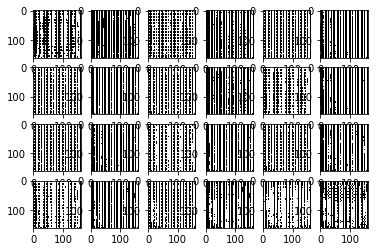

0.999481091376


In [41]:
test_prediction = lasagne.layers.get_output(layer, deterministic=True)
predict_fn = theano.function([input_var], [theano.tensor.argmax(test_prediction, axis=1)])
p1 = predict_fn(test_data[1])
print(type(p1))
p1 = np.array(p1)
print(p1.shape)
display_numpy(p1[0][0])
print(binary_jaccard_index_test(p1, test_seg[1]))

In [15]:
input_var = theano.tensor.tensor5()
target_var = theano.tensor.tensor5()


layer = lasagne.layers.InputLayer((None, 1, 24, 160, 160), input_var)
layer = start(layer)
tmp1 = layer
layer = contracting_block(layer)
tmp2 = layer
layer = contracting_block(layer)
tmp3 = layer
layer = contracting_block(layer)
layer = expanding_block(layer, tmp3)
#tmp4 = layers.Conv3DLayer(layer, num_filters=1, filter_size=(1, 1, 1), stride=1, pad=0)
layer = expanding_block(layer, tmp2)
#tmp5 = layers.Conv3DLayer(layer, num_filters=1, filter_size=(1, 1, 1), stride=1, pad=0)
layer = expanding_final(layer, tmp1)
#tmp6 = layers.Conv3DLayer(layer, num_filters=1, filter_size=(1, 1, 1), stride=1, pad=0)
#lasagne.regularization.regularize_network_params(layer, lasagne.regularization.l2)

#prediction = lasagne.layers.DenseLayer(layer, 2, nonlinearity=lasagne.nonlinearities.softmax)
prediction = lasagne.layers.get_output(layer)

#uporabiti pravi loss metric
#loss = lasagne.objectives.squared_error(prediction, target_var)
loss = binary_jaccard_index(prediction, target_var)
loss = loss.mean() #+ 1e-4 * lasagne.regularization.regularize_network_params(layer, lasagne.regularization.l2)

#print(loss.eval())

# create parameter update expressions
params = lasagne.layers.get_all_params(layer, trainable=True)
# learning_rate(clanek)=0.00005
updates = lasagne.updates.adam(loss, params, learning_rate=0.0001, beta1=0.1, beta2=0.001)

# compile training function that updates parameters and returns training loss
train_fn = theano.function([input_var, target_var], [loss, prediction], updates=updates)

# train network (assuming you've got some training data in numpy arrays)
for epoch in range(1000):
    #visualize.plot_conv_weights(layer)
    #print(lasagne.utils.floatX(prediction).shape)
    loss = train_fn(train_data, train_seg)
    #print(loss[1].shape)
    #print(type(loss[1]))
    #print(loss[1][1][0][10][50][25:75])
    #print(np.min(loss[1]))
    #display_numpy(loss[1][0][0]) #tole odkomentiraj za slikce :)
    #theano.printing.pprint(prediction[2][2]) 
    print("Epoch %d: Loss %g" % (epoch + 1, loss[0]))
    

#cm = confusion_matrix(, loss[1])
#plt.matshow(cm)
#plt.title('Confusion matrix')
#plt.colorbar()
#plt.ylabel('True label')
#plt.xlabel('Predicted label')
#plt.show()

Epoch 1: Loss 0.999181
Epoch 2: Loss 0.999175
Epoch 3: Loss 0.99917
Epoch 4: Loss 0.999164


KeyboardInterrupt: 

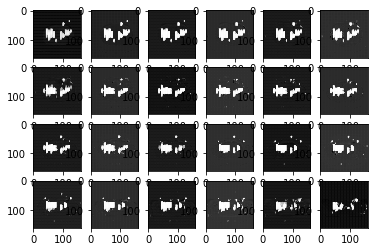

In [12]:
display_numpy(loss[1][0][0])

In [17]:
print(loss[1][1][0][10][50][25:75])
print(train_seg[1][0][10][50][25:75])

[ 0.42383817  0.42755674  0.42364552  0.42765284  0.42383401  0.42763247
  0.42370539  0.42778085  0.42379395  0.42807431  0.42403912  0.42847873
  0.42440574  0.42859634  0.42445203  0.42858801  0.42447421  0.42857559
  0.42433226  0.4287516   0.42453231  0.42679306  0.42585264  0.42927692
  0.42141332  0.42707927  0.42048577  0.42746581  0.42977311  0.43007534
  0.42177497  0.42815648  0.42495857  0.42908213  0.42286045  0.43013008
  0.42544304  0.43147057  0.43011937  0.43601275  0.42808841  0.43022833
  0.42873422  0.43707984  0.43006351  0.43439169  0.42804293  0.4323404
  0.42693408  0.43250688]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [19]:
print(loss[1][1][0][15][83][40:90])
print(train_seg[1][0][15][83][40:90])

[ 0.42133782  0.41599627  0.84490174  0.97961516  0.98164077  0.98426246
  0.98258455  0.9787911   0.96450727  0.93099175  0.98039879  0.99565401
  0.9979723   0.9991421   0.9989123   0.99857225  0.99672793  0.99147921
  0.99296831  0.9943709   0.99704733  0.9984271   0.99840368  0.99820089
  0.99697144  0.9935178   0.99380857  0.9938208   0.99538192  0.99632485
  0.99733147  0.99812704  0.99819941  0.99837261  0.99725073  0.99497332
  0.99148396  0.98378641  0.88652746  0.43606524  0.42528911  0.42313005
  0.42448037  0.4129919   0.42901373  0.41691308  0.42521601  0.42671895
  0.4209536   0.42015169]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [49]:
print(sum(sum(sum(sum(loss[1][1])))))
print(sum(sum(sum(sum(loss[1][1]))))/(160*160*24))
print(sum(sum(sum(sum(train_seg[1])))))
print(sum(sum(sum(sum(train_seg[1]))))/(160*160*24))

min_sum = 0
max_sum = 0
min1 = 1
min1_i = 1
max1 = 0
max1_i = 0
for ni,i in enumerate(loss[1][1]):
    for nj,j in enumerate(i):
        for nk,k in enumerate(j):
            for nl,l in enumerate(k):
                if l<min1:
                    min1=l
                    min1_i=train_seg[1][ni][nj][nk][nl]
                if l>max1:
                    max1=l
                    max1_i = train_seg[1][ni][nj][nk][nl]
                min_sum += min(l, train_seg[1][ni][nj][nk][nl])
                max_sum += max(l, train_seg[1][ni][nj][nk][nl])

print(min_sum)
print(max_sum)

print(min1)
print(min1_i)
print(max1)
print(max1_i)

282342.494963
0.459541821229
358.0
0.000582682291667
357.02113731
282343.473826
0.275692654342
0.0
0.99990649117
0.0


In [35]:
1-min_sum/max_sum

0.99873550774001496